In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("Bronze-Analysis") \
    .config("spark.local.dir", "/spark_temp")\
    .config("spark.driver.memory", "2g") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/11 12:23:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


25/10/11 12:23:10 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in standalone/kubernetes and LOCAL_DIRS in YARN).


In [2]:
df_accidents = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("./data/Accidents0515.csv")

df_casualties = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("./data/Casualties0515.csv")

df_vehicles = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("./data/Vehicles0515.csv")

print("Dados carregados")

Dados carregados


In [3]:
# CÉLULA 3 - Estatísticas Básicas
print("📊 RESUMO DOS DATASETS BRONZE:")
print(f"🚗 Acidentes: {df_accidents.count():,} linhas, {len(df_accidents.columns)} colunas")
print(f"👥 Vítimas: {df_casualties.count():,} linhas, {len(df_casualties.columns)} colunas")  
print(f"🚙 Veículos: {df_vehicles.count():,} linhas, {len(df_vehicles.columns)} colunas")

📊 RESUMO DOS DATASETS BRONZE:


🚗 Acidentes: 1,780,653 linhas, 32 colunas


👥 Vítimas: 2,402,909 linhas, 15 colunas


🚙 Veículos: 3,262,270 linhas, 22 colunas


In [4]:
print("🎯 AMOSTRA - Primeiros registros:")
print("\n--- ACIDENTES ---")
df_accidents.select("Accident_Index", "Accident_Severity", "Date", "Time").show(5)

print("\n--- VÍTIMAS ---")
df_casualties.select("Accident_Index", "Casualty_Severity", "Age_of_Casualty").show(5)

print("\n--- VEÍCULOS ---") 
df_vehicles.select("Accident_Index", "Vehicle_Type", "Age_of_Driver").show(5)

🎯 AMOSTRA - Primeiros registros:

--- ACIDENTES ---


+--------------+-----------------+----------+-------------------+
|Accident_Index|Accident_Severity|      Date|               Time|
+--------------+-----------------+----------+-------------------+
| 200501BS00001|                2|04/01/2005|2025-10-11 17:42:00|
| 200501BS00002|                3|05/01/2005|2025-10-11 17:36:00|
| 200501BS00003|                3|06/01/2005|2025-10-11 00:15:00|
| 200501BS00004|                3|07/01/2005|2025-10-11 10:35:00|
| 200501BS00005|                3|10/01/2005|2025-10-11 21:13:00|
+--------------+-----------------+----------+-------------------+
only showing top 5 rows

--- VÍTIMAS ---
+--------------+-----------------+---------------+
|Accident_Index|Casualty_Severity|Age_of_Casualty|
+--------------+-----------------+---------------+
| 200501BS00001|                2|             37|
| 200501BS00002|                3|             37|
| 200501BS00003|                3|             62|
| 200501BS00004|                3|             30|
| 200501

+--------------+------------+-------------+
|Accident_Index|Vehicle_Type|Age_of_Driver|
+--------------+------------+-------------+
| 200501BS00001|           9|           74|
| 200501BS00002|          11|           42|
| 200501BS00003|          11|           35|
| 200501BS00003|           9|           62|
| 200501BS00004|           9|           49|
+--------------+------------+-------------+
only showing top 5 rows


In [5]:
df_accidents.write.mode("overwrite").option("compression", "snappy").parquet("./bronze/Accidents0515")
df_casualties.write.mode("overwrite").option("compression", "snappy").parquet("./bronze/Casualties0515")
df_vehicles.write.mode("overwrite").option("compression", "snappy").parquet("./bronze/Vehicles0515")

25/10/11 12:23:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
df_joined = df_accidents \
    .join(df_vehicles, on="Accident_Index", how="inner") \
    .join(df_casualties, on=["Accident_Index", "Vehicle_Reference"], how="inner")

print(f"Dataframe final: {df_joined.count():,} linhas, {len(df_joined.columns)} colunas")
df_joined.printSchema()

Dataframe final: 2,402,909 linhas, 66 colunas
root
 |-- Accident_Index: string (nullable = true)
 |-- Vehicle_Reference: integer (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: integer (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Detail: integer (nullable = true)


### Grafico Quantidade de Acidentes por severidade

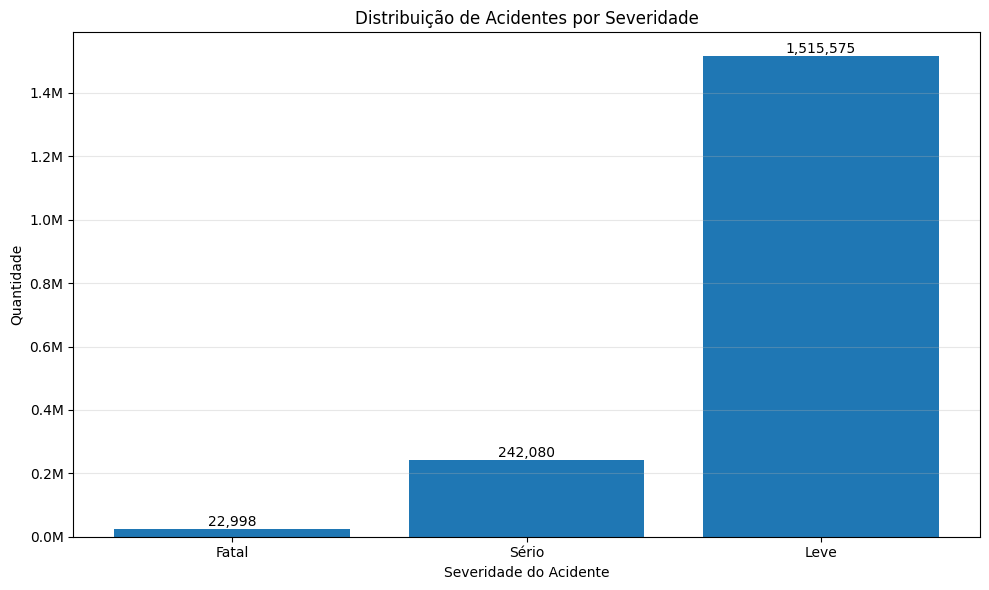

In [7]:
accident_severity = df_accidents.groupBy("Accident_Severity").count().orderBy("Accident_Severity").toPandas()

severity_map = {1: 'Fatal', 2: 'Sério', 3: 'Leve'}
accident_severity['Severity_Label'] = accident_severity['Accident_Severity'].map(severity_map)

plt.figure(figsize=(10, 6))
bars = plt.bar(accident_severity['Severity_Label'], accident_severity['count'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom')

plt.xlabel("Severidade do Acidente")
plt.ylabel("Quantidade")
plt.title("Distribuição de Acidentes por Severidade")

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Acidentes por dia da semana

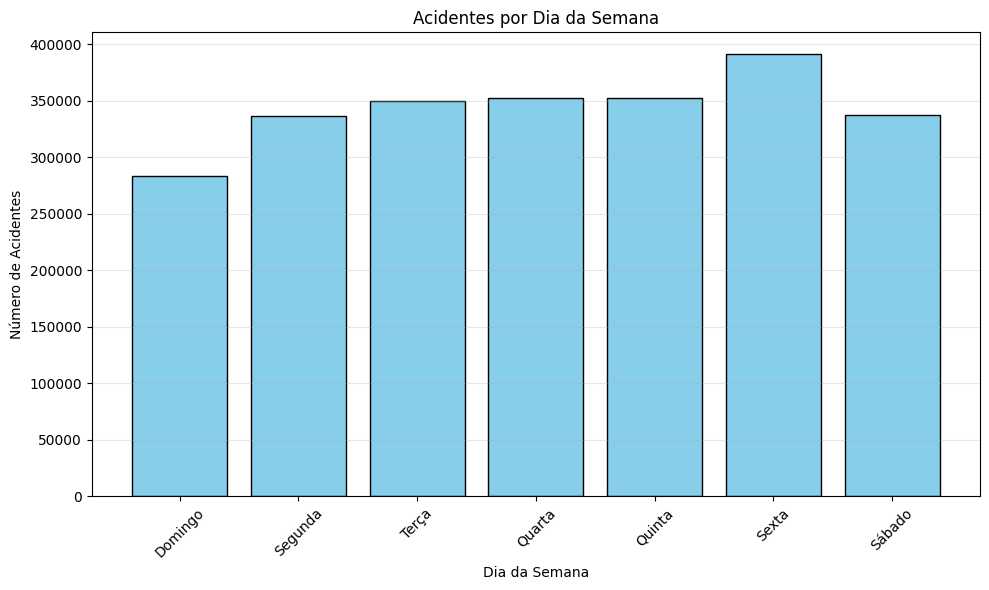

In [8]:
day_data = df_joined.groupBy("day_of_week").count().orderBy("day_of_week").toPandas()
days_map = {1: 'Domingo', 2: 'Segunda', 3: 'Terça', 4: 'Quarta', 5: 'Quinta', 6: 'Sexta', 7: 'Sábado'}
day_data['day_name'] = day_data['day_of_week'].map(days_map)

plt.figure(figsize=(10, 6))
plt.bar(day_data['day_name'], day_data['count'], color='skyblue', edgecolor='black')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Acidentes')
plt.title('Acidentes por Dia da Semana')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Severidade dos acidentes por condições climaticas

<Figure size 1000x600 with 0 Axes>

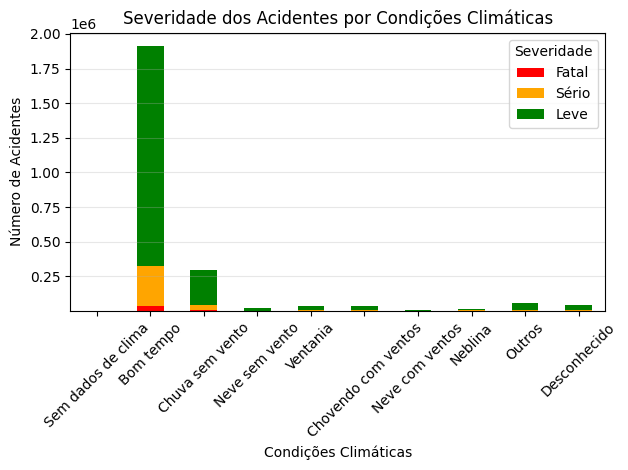

In [9]:
weather_data = df_joined.groupBy("weather_conditions", "accident_severity").count().toPandas()
pivot_weather = weather_data.pivot(index='weather_conditions', columns='accident_severity', values='count').fillna(0)
weather_map = {-1:'Sem dados de clima' ,1: 'Bom tempo', 2: 'Chuva sem vento', 3: 'Neve sem vento', 4: 'Ventania', 5:'Chovendo com ventos', 6: 'Neve com ventos', 7: 'Neblina', 8: 'Outros', 9: 'Desconhecido'}
pivot_weather.index = pivot_weather.index.map(weather_map)

plt.figure(figsize=(10, 6))
pivot_weather.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'])
plt.xlabel('Condições Climáticas')
plt.ylabel('Número de Acidentes')
plt.title('Severidade dos Acidentes por Condições Climáticas')
plt.legend(['Fatal', 'Sério', 'Leve'], title='Severidade')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Urbano X Rural

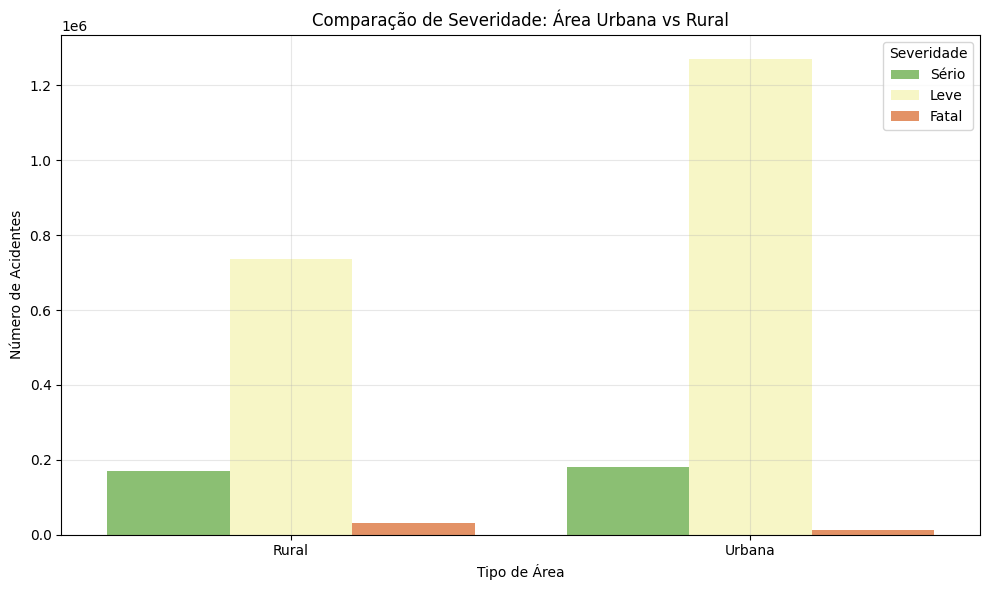

In [10]:
urban_rural_data = df_joined.groupBy("urban_or_rural_area", "accident_severity").count().toPandas()
area_map = {1: 'Urbana', 2: 'Rural'}
severity_map = {1: 'Fatal', 2: 'Sério', 3: 'Leve'}
urban_rural_data['area_label'] = urban_rural_data['urban_or_rural_area'].map(area_map)
urban_rural_data['severity_label'] = urban_rural_data['accident_severity'].map(severity_map)

plt.figure(figsize=(10, 6))
sns.barplot(data=urban_rural_data, x='area_label', y='count', hue='severity_label', palette='RdYlGn_r')
plt.xlabel('Tipo de Área')
plt.ylabel('Número de Acidentes')
plt.title('Comparação de Severidade: Área Urbana vs Rural')
plt.legend(title='Severidade')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Tendencia de acidentes por idade do veiculo

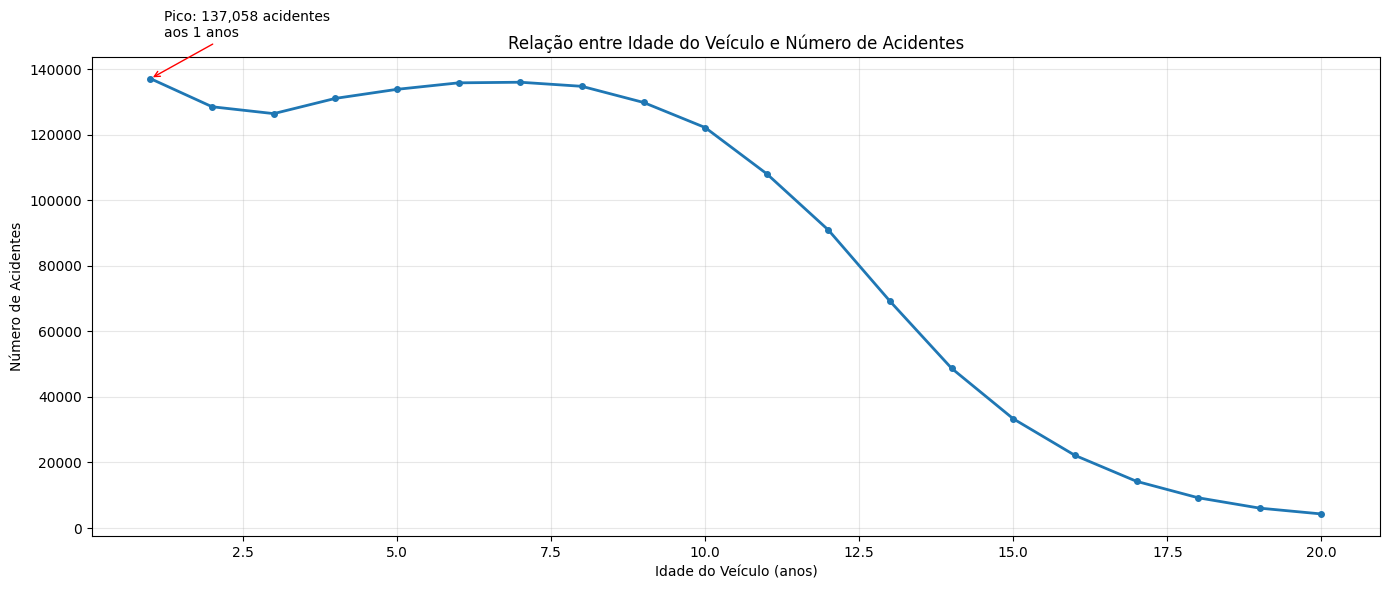

In [11]:
exact_age_data = df_joined.select(
    F.col("age_of_vehicle").cast("int").alias("vehicle_age"),
    F.col("accident_index")
).filter(F.col("age_of_vehicle").isNotNull() & 
         (F.col("age_of_vehicle") >= 0) & 
         (F.col("age_of_vehicle") <= 20))

exact_age_count = exact_age_data.groupBy("vehicle_age").count().orderBy("vehicle_age").toPandas()

plt.figure(figsize=(14, 6))
plt.plot(exact_age_count['vehicle_age'], exact_age_count['count'], marker='o', linewidth=2, markersize=4)
plt.xlabel('Idade do Veículo (anos)')
plt.ylabel('Número de Acidentes')
plt.title('Relação entre Idade do Veículo e Número de Acidentes')
plt.grid(True, alpha=0.3)

max_age = exact_age_count.loc[exact_age_count['count'].idxmax()]
plt.annotate(f'Pico: {max_age["count"]:,} acidentes\naos {max_age["vehicle_age"]} anos', 
             xy=(max_age['vehicle_age'], max_age['count']),
             xytext=(10, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()